The laboratory work is based on the paper \[Jin-Guo Liu and Lei Wang.
Differentiable learning of quantum circuit Born machines. 
Phys. Rev. A 98, 062324\]

**Problem**: we have a dataset of squered images that need to be classified into two classes: 1) bars/stripes and 2) others.


**Goal**: Study Neural Network with application to classification problem.

Neural Network is a mathematical model of biological neural net. It is a composition of neuron layers connected to eachother. Each neuron (layer) can be represented as mathematical function. Along the net we transform input vector to output by appling transformation of each layer. So as result output equals $a = f(x,\theta)$, where $x$ is input data and $\theta$ parameters.

During traning process we minimaize loss fuction in form of CrossEntropy:

$$\mathit{L}(x) = - \frac{1}{N} \sum_1^N p(x)\mathrm{Log} q(x)$$

where $p$ is true probability distribution and $q$ is probability distribution predicted by model. In case of classification problem $p$ distribution is 1 for the true label and 0 for others, while $q$ values have to be in range $[0..1]$. 


Oun of the popular choice of neural nets for image analysis is a [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network).

General tusks: 
1) Explain how Neural Network works.

2) Explain how we can train it. What backpropagation is?

Another goal of this work is to study [PyTorch](https://pytorch.org/) one of most popular machine learning framework.

In [1]:
import numpy as np
import scipy

import matplotlib.pyplot as plt
from matplotlib import patches

import torch
from torch import nn


As a first step we need dataset for formulated above problem.
So, we start with building a generator of image set.

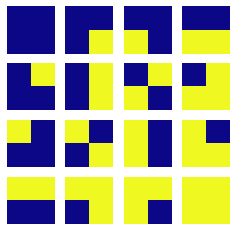

In [2]:
def generate_pics(N:int, B:int):
    """
    Generate batch of B binary images of size N x N returned as array B x N x N.
    """
    return np.random.randint(low=0, high=2, size=(B,N,N)).astype(bool)

def generate_all_pics(N:int):
    """
    Generate all possible black and white images of size N x N.
    """
    all_bit_values = np.array([False, True])
    npixels = N**2
    list_of_coordinates = np.meshgrid( *(all_bit_values,)*npixels, indexing='ij' ) 
    return np.stack(list_of_coordinates, axis=-1).reshape((-1,N,N))

def check_if_striped(bpic):
    """
    For batch of images bpic (B x N x N) returns boolean array (N),
    marking if the image consists of stripes (either vertical or horizontal).
    """
    return ( np.all(bpic[...,0,None,:]==bpic, axis=(-1,-2)) 
           | np.all(bpic[...,:,0,None]==bpic, axis=(-1,-2))
           )

def desired_distribution(N: int):
    """
    Return uniform distribution on set of images showing stripes.
    """
    bpics = generate_all_pics(N=N)
    is_striped = check_if_striped(bpics)
    return is_striped.astype(np.float64)/np.sum(is_striped)

def plot_pic(images, labels=None, maxpics=15**2):
    """
    Show batch of images.
    Arguments: 
        `images` is array of shape B x N x N.
        `labels` is either boolean array or array of values from interval [0,1] of size B.
        `maxpics` is number of images to show if B is larger than maxpics.
    """
    B = len(images)    
    assert B>0
    N, M = images[0].shape
    assert N==M
    
    assert labels is None or len(labels) == B    

    maxpics = np.minimum(maxpics, B)
    ncols = int(np.ceil(np.sqrt(maxpics)))
    
    fig, axs = plt.subplots(ncols, ncols, figsize=(ncols*1,)*2)
    axs = np.concatenate(axs)
    for k, ax in enumerate(axs):
        ax.set_axis_off()        
        if k<maxpics:
            if labels is not None:
                label = labels[k]
                if label.ndim==0: label = (1-float(label),float(label))
            else:
                label = None
            
            cmap = 'plasma' if label is None else 'Wistia' if (label[1]>label[0]) else 'cool'
            image = images[k]            
            ax.imshow(image, cmap=cmap, clim=(0,1))
        
            if label is not None:
                ax.add_patch(patches.Rectangle((-0.5, -0.75), label[0]*N, 0.25,
                     edgecolor = 'blue', facecolor = 'blue', fill=True, lw=5))
                ax.add_patch(patches.Rectangle((-0.5+(1-label[1])*N, -0.75), label[1]*N, 0.25,
                     edgecolor = 'red', facecolor = 'red', fill=True, lw=5))
                
            
                
    plt.show()

    
bpics = generate_all_pics(N=2)
# bpics = generate_pics(N=2, B=15**2)
plot_pic(bpics)
# print(f"{desired_distribution(N=2)}")

Then we create a dataset of images with indication of their class. We will use it further in training and testing.

In [3]:
class BarsAndStripes(torch.utils.data.Dataset):
    def __init__(self, N, B=None, transform=None, target_transform=None):
        """
        Create dataset of black and white images `N` x `N`.
        Each image has either label 1, if it shows bars and stripes,
        or label 0, otherwise.
        Number of images is specified in argument `B`, then random images with repetitions are taken.
        If B is None or not specified, then all images of given size are generated.
        """
        assert isinstance(N, int) and N>0
        self._N = N
        if B is None:
            self._data = generate_all_pics(self._N)
        else:
            assert isinstance(B, int) and B>0
            self._data = generate_pics(self._N, B)
        self.transform = transform
        self.target_transform = target_transform        
    
    def __len__(self):
        """
        Length of the dataset.
        """
        return self._data.shape[0]

    def __getitem__(self, idx):
        """
        Return sample `idx` from the dataset.
        """
        image = self._data[idx]
        label = check_if_striped(image)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
    @property
    def N(self):
        return self._N
    
def plot_dataset(dataset):
    images, labels = zip(*dataset)
    plot_pic(images, labels)    
    

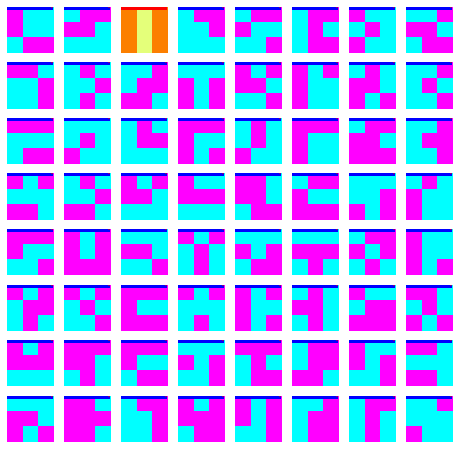

In [4]:
# dataset = BarsAndStripes(N=4, B=256)
dataset = BarsAndStripes(N=3)

B = len(dataset)
transforms = {
    'transform': lambda x: torch.tensor(x.astype(np.float32)),
    # 'target_transform': lambda y: torch.zeros(2, dtype=torch.float).scatter_(0, torch.tensor(y.astype(np.int64)), value=1)
    'target_transform': lambda y: torch.tensor(y.astype(np.int64))
}

dataset = BarsAndStripes(N=3, **transforms)

training_data, test_data = torch.utils.data.random_split(dataset, [int(np.round(B*f)) for f in[0.8,0.2]])

train_dataloader = torch.utils.data.DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

# plot_dataset(test_data)

images, labels = next(iter(test_dataloader))
plot_pic(images, labels)
# labels

Now, when we have dataset for training and testing, we can create a neural network.
But before do so, it is important to understande the following:

3) Is it possible to solve bars and stripes problem with Neural Network?  
- What minimal archetecture should be? 
- Can we solve it with network?
- Can we solve this problem with net that containes only linear layers or we have to use nonlinear net?

4) Can you find analiticaly transform that solve such problem? Can you express this transformation in terms of neural network?

Below you can find an example of net that solve classification problem. 

NeuralNetwork(
  (conv): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1))
    (1): Tanh()
    (2): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=5, out_features=2, bias=True)
    (1): Tanh()
  )
)


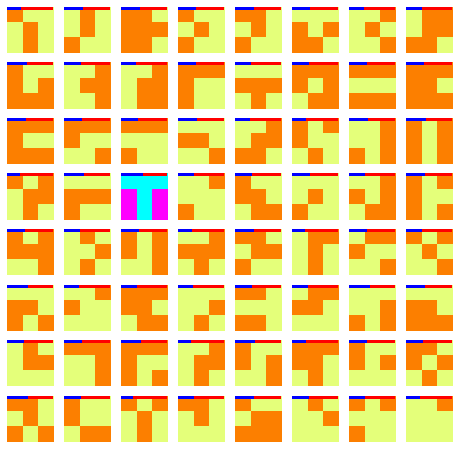

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, N, nfeatures=5, kernelsz=3, poolsz=1):
        super().__init__()
        self._N = N
        self.conv = nn.Sequential(
            nn.Conv2d(1,nfeatures,kernelsz),
            nn.Tanh(),
            nn.MaxPool2d(poolsz),
        )
        N_output = (N-kernelsz+1)//poolsz
        self.linear = nn.Sequential(
            nn.Linear(N_output**2*nfeatures, 2),
            nn.Tanh(),
        )

    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        features = self.conv(x)
        flat = features.view(features.shape[0],-1)
        logits = self.linear(flat)
        return logits
    
model = NeuralNetwork(N=dataset.N)
print(model)

images, labels = next(iter(test_dataloader))
prediction = nn.Softmax(dim=1)(model(images))
plot_pic(images, prediction.detach())

Example of training function that uses stochastic gradient descent

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [7]:
learning_rate = 1e-3
epochs = 10

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.876184  [    0/  410]
Test Error: 
 Accuracy: 5.9%, Avg loss: 0.877426 

Epoch 2
-------------------------------
loss: 0.866776  [    0/  410]
Test Error: 
 Accuracy: 5.9%, Avg loss: 0.871974 

Epoch 3
-------------------------------
loss: 0.834889  [    0/  410]
Test Error: 
 Accuracy: 6.9%, Avg loss: 0.870020 

Epoch 4
-------------------------------
loss: 0.850855  [    0/  410]
Test Error: 
 Accuracy: 8.8%, Avg loss: 0.859862 

Epoch 5
-------------------------------
loss: 0.828140  [    0/  410]
Test Error: 
 Accuracy: 8.8%, Avg loss: 0.853971 

Epoch 6
-------------------------------
loss: 0.807164  [    0/  410]
Test Error: 
 Accuracy: 10.8%, Avg loss: 0.848586 

Epoch 7
-------------------------------
loss: 0.809168  [    0/  410]
Test Error: 
 Accuracy: 10.8%, Avg loss: 0.834619 

Epoch 8
-------------------------------
loss: 0.791962  [    0/  410]
Test Error: 
 Accuracy: 10.8%, Avg loss: 0.832889 

Epoch 9
---------------------

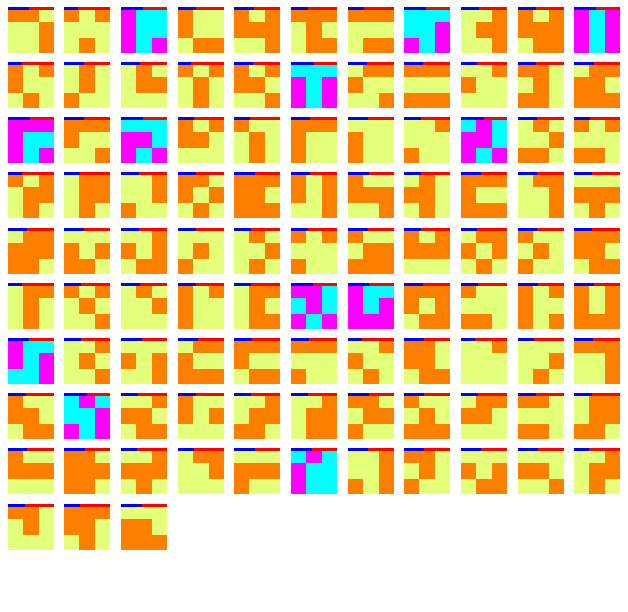

In [8]:
images = torch.stack([image for image, _label in test_data], dim=0)
# print(model(images).shape)

prediction = nn.Softmax(dim=1)(model(images))
plot_pic(images, prediction.detach())    


**Tasks:**
What do you think about it performance? Can you improve it? Try to change number of layers or nuerons. How it will affect the result? 

If you experiance problems with convergence, you can try change traning algorithm.

### Challenge! 

5) Do your best to build Neural Network that perform more accurate classification and have smallest size.